In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    GridSearchCV,
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    silhouette_samples,
    silhouette_score,
)

from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
import seaborn as sns
import shap

# 한글 깨지지 않게
plt.rcParams["font.family"] = "Malgun Gothic"

shap.initjs()

In [2]:
data = pd.read_csv("Social_Network_Ads.csv", index_col=0)

In [3]:
data.head()

,Gender,Age,EstimatedSalary,Purchased
User ID,,,,
15624510,Male,19,19000,0
15810944,Male,35,20000,0
15668575,Female,26,43000,0
15603246,Female,27,57000,0
15804002,Male,19,76000,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 15624510 to 15594041
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Gender           400 non-null    object
 1   Age              400 non-null    int64 
 2   EstimatedSalary  400 non-null    int64 
 3   Purchased        400 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 15.6+ KB


In [5]:
data.describe()

,Age,EstimatedSalary,Purchased
count,400.000000,400.000000,400.000000
mean,37.655000,69742.500000,0.357500
std,10.482877,34096.960282,0.479864
min,18.000000,15000.000000,0.000000
25%,29.750000,43000.000000,0.000000
50%,37.000000,70000.000000,0.000000
75%,46.000000,88000.000000,1.000000
max,60.000000,150000.000000,1.000000


In [6]:
data.describe(include="O")

,Gender
count,400
unique,2
top,Female
freq,204


In [7]:
data.isnull().sum()

Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

In [8]:
data["Gender"].value_counts()

Gender
Female    204
Male      196
Name: count, dtype: int64

In [9]:
# 연령대 구분 함수
def categorize_age(age):
    if age < 10:
        return "10대 미만"
    elif 10 <= age < 20:
        return "10대"
    elif 20 <= age < 30:
        return "20대"
    elif 30 <= age < 40:
        return "30대"
    elif 40 <= age < 50:
        return "40대"
    elif 50 <= age < 60:
        return "50대"
    else:
        return "60대 이상"


# 새로운 컬럼 'AgeGroup' 추가
data["AgeGroup"] = data["Age"].apply(categorize_age)

# AgeGroup을 범주형 데이터로 변환하고 순서 지정
age_order = ["10대 미만", "10대", "20대", "30대", "40대", "50대", "60대 이상"]
data["AgeGroup"] = pd.Categorical(data["AgeGroup"], categories=age_order, ordered=True)

data["AgeGroup"].value_counts()

AgeGroup
30대       138
40대       109
20대        88
50대        46
10대        12
60대 이상      7
10대 미만      0
Name: count, dtype: int64

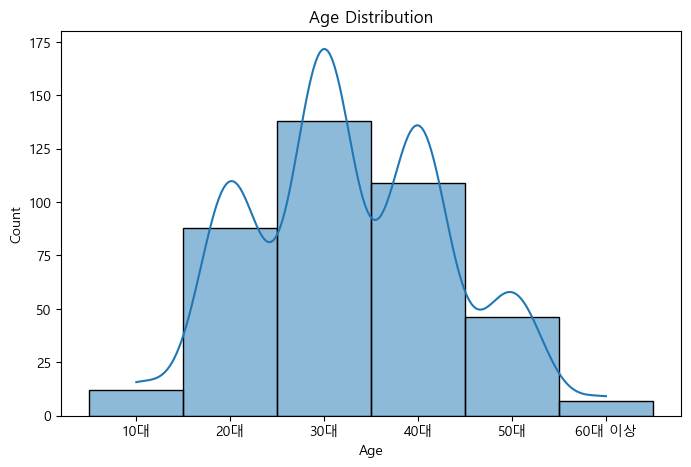

In [10]:
# 히스토그램을 이용한 연령대 분포 시각화
plt.figure(figsize=(8, 5))
sns.histplot(data["AgeGroup"], kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

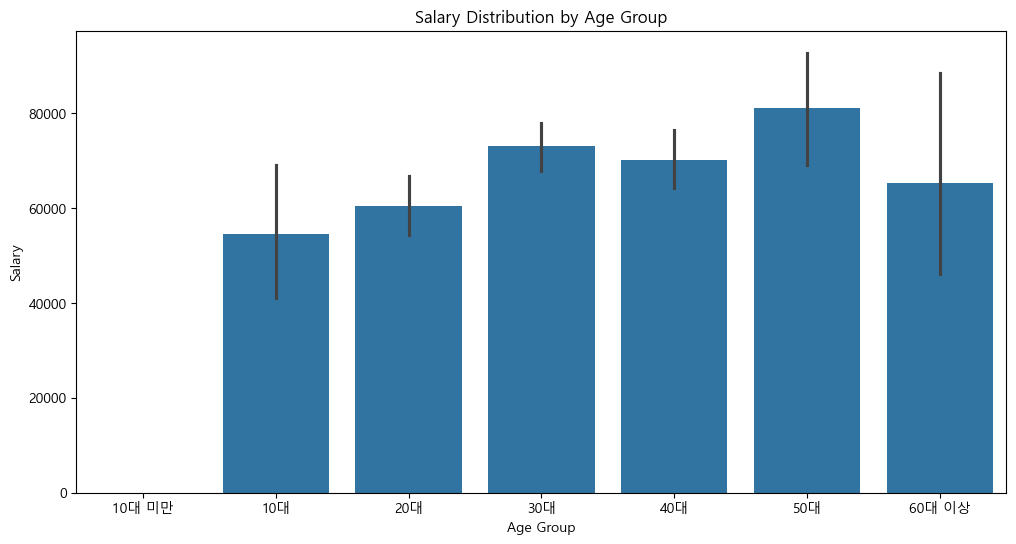

In [11]:
plt.figure(figsize=(12, 6))
sns.barplot(data, x="AgeGroup", y="EstimatedSalary")

plt.title("Salary Distribution by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Salary")
plt.show()

In [12]:
salary_by_agegroup = data.groupby("AgeGroup")["EstimatedSalary"].mean().reset_index()

salary_by_agegroup

C:\Users\user\AppData\Local\Temp\ipykernel_21848\3908924587.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  salary_by_agegroup = data.groupby("AgeGroup")["EstimatedSalary"].mean().reset_index()


,AgeGroup,EstimatedSalary
0,10대 미만,NaN
1,10대,54500.000000
2,20대,60443.181818
3,30대,73079.710145
4,40대,70201.834862
5,50대,81086.956522
6,60대 이상,65285.714286


In [13]:
data[data["AgeGroup"] == "10대"].sort_values(by="EstimatedSalary", ascending=False)

,Gender,Age,EstimatedSalary,Purchased,AgeGroup
User ID,,,,,
15578738,Female,18,86000,0,10대
15807909,Male,19,85000,0,10대
15628972,Male,18,82000,0,10대
15804002,Male,19,76000,0,10대
15662901,Male,19,70000,0,10대
15666141,Female,18,68000,0,10대
15746737,Male,18,52000,0,10대
15764195,Female,18,44000,0,10대
15662067,Female,19,26000,0,10대


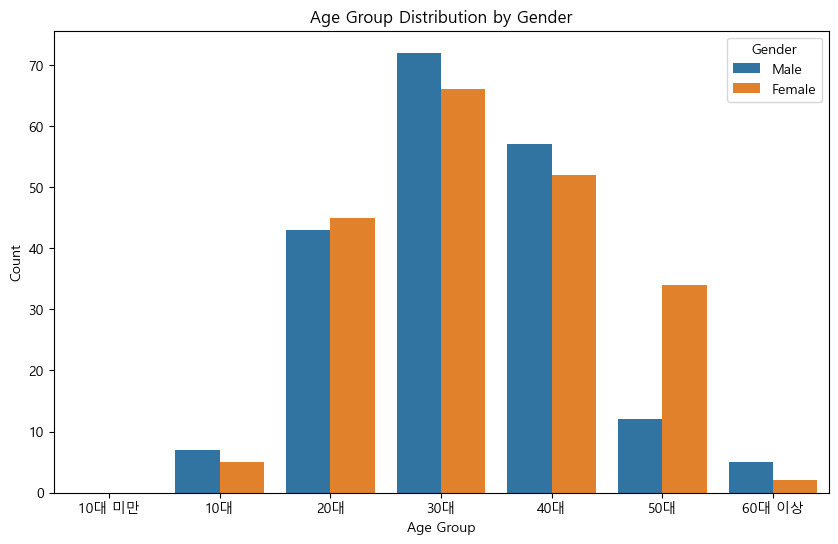

In [14]:
# 성별에 따른 연령대 분포 확인
plt.figure(figsize=(10, 6))
sns.countplot(x="AgeGroup", hue="Gender", data=data)
plt.title("Age Group Distribution by Gender")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.legend(title="Gender")
plt.show()

In [15]:
# 성별에 따른 연령대 그룹별 분포 계산
age_gender_distribution = (
    data.groupby(["AgeGroup", "Gender"]).size().unstack(fill_value=0)
)

age_gender_distribution

C:\Users\user\AppData\Local\Temp\ipykernel_21848\2886235199.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["AgeGroup", "Gender"]).size().unstack(fill_value=0)


Gender,Female,Male
AgeGroup,,
10대 미만,0,0
10대,5,7
20대,45,43
30대,66,72
40대,52,57
50대,34,12
60대 이상,2,5


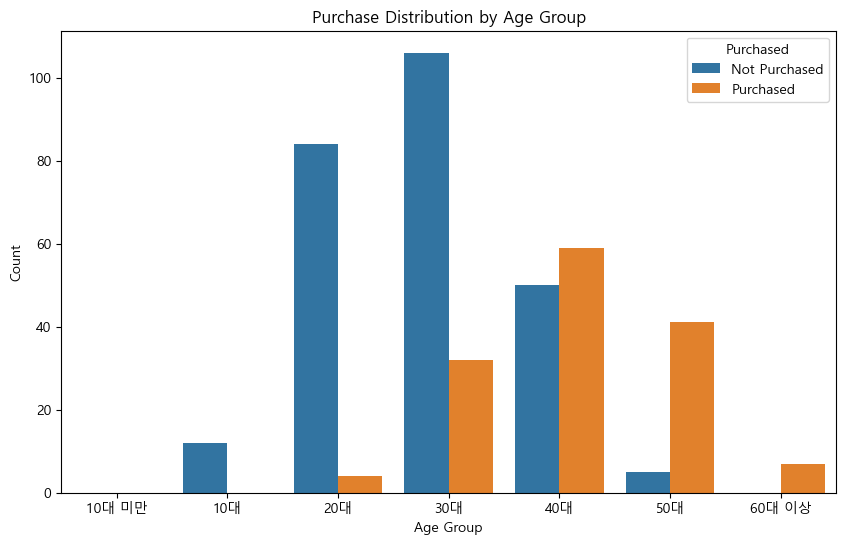

In [16]:
# 연령대별 구매 여부 확인
plt.figure(figsize=(10, 6))
sns.countplot(x="AgeGroup", hue="Purchased", data=data)
plt.title("Purchase Distribution by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.legend(title="Purchased", labels=["Not Purchased", "Purchased"])
plt.show()

In [17]:
# 연령대별 구매 여부 계산
purchase_distribution = (
    data.groupby(["AgeGroup", "Purchased"]).size().unstack(fill_value=0)
)

purchase_distribution

C:\Users\user\AppData\Local\Temp\ipykernel_21848\2113991611.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["AgeGroup", "Purchased"]).size().unstack(fill_value=0)


Purchased,0,1
AgeGroup,,
10대 미만,0,0
10대,12,0
20대,84,4
30대,106,32
40대,50,59
50대,5,41
60대 이상,0,7


In [18]:
filtered_df = data[
    (data["EstimatedSalary"] >= 60000) & (data["EstimatedSalary"] <= 80000)
]

count = filtered_df.shape[0]

print(f"Number of users: {count}")

Number of users: 105


c:\Users\user\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


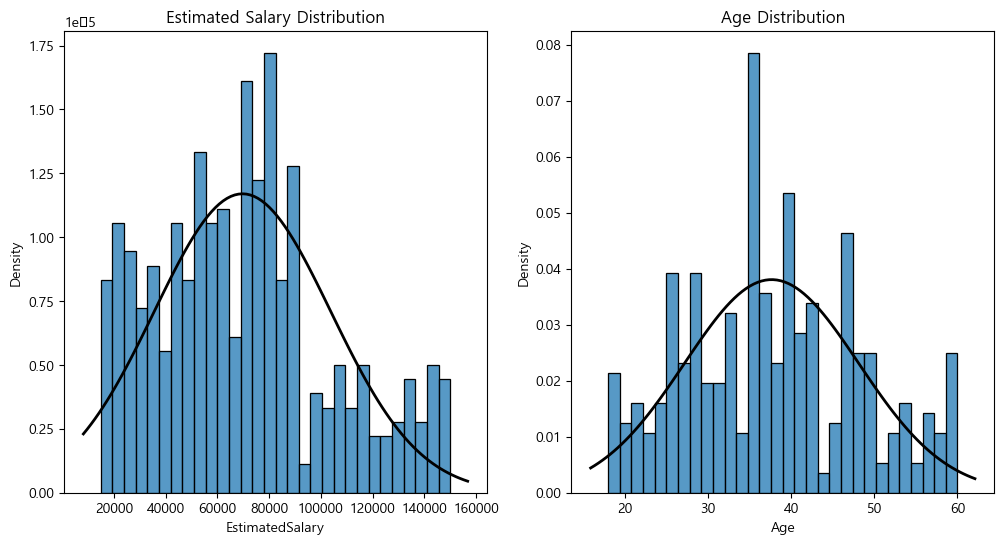

In [19]:
# 데이터의 분포를 시각화
plt.figure(figsize=(12, 6))

# EstimatedSalary와 Age에 대한 히스토그램과 정규 분포 곡선
plt.subplot(1, 2, 1)
sns.histplot(data["EstimatedSalary"], kde=False, stat="density", bins=30)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, data["EstimatedSalary"].mean(), data["EstimatedSalary"].std())
plt.plot(x, p, "k", linewidth=2)
plt.title("Estimated Salary Distribution")

plt.subplot(1, 2, 2)
sns.histplot(data["Age"], kde=False, stat="density", bins=30)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, data["Age"].mean(), data["Age"].std())
plt.plot(x, p, "k", linewidth=2)
plt.title("Age Distribution")

plt.show()

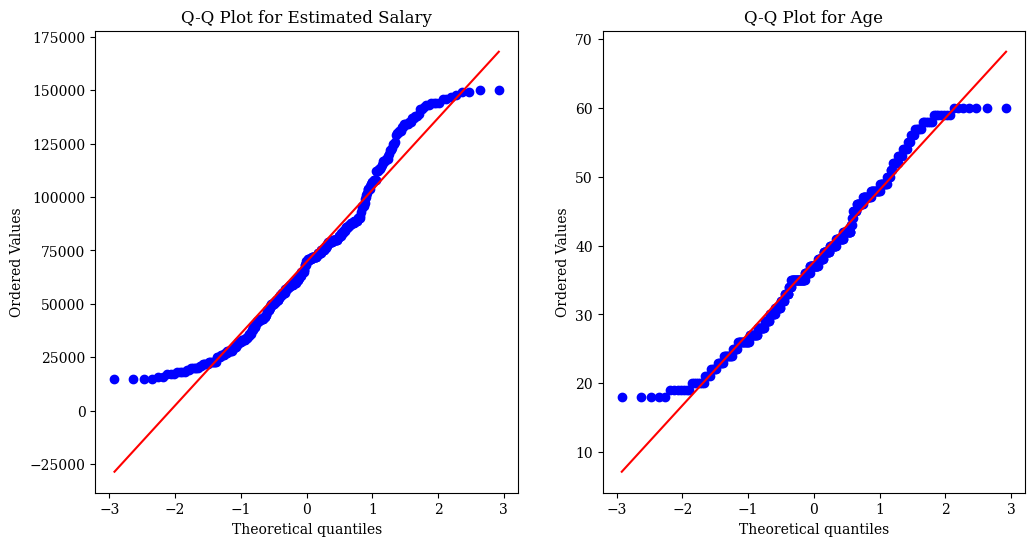

In [20]:
# Q-Q 플롯을 시각화
plt.figure(figsize=(12, 6))
plt.rcParams["font.family"] = "serif"

# EstimatedSalary와 Age에 대한 Q-Q 플롯
plt.subplot(1, 2, 1)
stats.probplot(data["EstimatedSalary"], dist="norm", plot=plt)
plt.title("Q-Q Plot for Estimated Salary")

plt.subplot(1, 2, 2)
stats.probplot(data["Age"], dist="norm", plot=plt)
plt.title("Q-Q Plot for Age")

plt.show()

In [21]:
data = data[data["AgeGroup"] != "60대 이상"]
data = data.drop(
    data[(data["AgeGroup"] == "10대") & (data["EstimatedSalary"] >= 77000)].index
)

In [22]:
data.drop(columns=["AgeGroup"], inplace=True)

In [23]:
# 데이터 인코딩
data["Gender"] = data["Gender"].map({"Male": 1, "Female": 0})

In [24]:
X = data.drop(columns=["Purchased", "Gender"])
y = data["Purchased"]

In [25]:
X

,Age,EstimatedSalary
User ID,,
15624510,19,19000
15810944,35,20000
15668575,26,43000
15603246,27,57000
15804002,19,76000
...,...,...
15691863,46,41000
15706071,51,23000
15654296,50,20000


In [26]:
y.value_counts()

Purchased
0    254
1    136
Name: count, dtype: int64

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12345
)

In [28]:
# 교차 검증 설정
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

In [29]:
# 1. 로지스틱 회귀 모델
# 파이프라인 생성
pipeline_log = Pipeline(
    [
        ("scaler", StandardScaler()),  # 데이터 전처리
        ("classifier", LogisticRegression(random_state=12345)),  # 모델
    ]
)
pipeline_log.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression(random_state=12345))])

In [30]:
# 교차 검증을 통한 성능 평가
accu_log = cross_val_score(pipeline_log, X, y, cv=cv, scoring="accuracy")
prec_log = cross_val_score(pipeline_log, X, y, cv=cv, scoring="precision")
recall_log = cross_val_score(pipeline_log, X, y, cv=cv, scoring="recall")
f1_log = cross_val_score(pipeline_log, X, y, cv=cv, scoring="f1")

# 평가 결과 출력
print(f"Cross-Validated Accuracy Scores: {accu_log}")
print(f"Mean Accuracy: {accu_log.mean():.2f}")

print(f"Cross-Validated Precision Scores: {prec_log}")
print(f"Mean Precision: {prec_log.mean():.2f}")

print(f"Cross-Validated Recall Scores: {recall_log}")
print(f"Mean Recall: {recall_log.mean():.2f}")

print(f"Cross-Validated F1 Scores: {f1_log}")
print(f"Mean F1 Score: {f1_log.mean():.2f}")

Cross-Validated Accuracy Scores: [0.85897436 0.83333333 0.85897436 0.82051282 0.85897436]
Mean Accuracy: 0.85
Cross-Validated Precision Scores: [0.86363636 0.79166667 0.83333333 0.88235294 0.81481481]
Mean Precision: 0.84
Cross-Validated Recall Scores: [0.7037037  0.7037037  0.74074074 0.55555556 0.78571429]
Mean Recall: 0.70
Cross-Validated F1 Scores: [0.7755102  0.74509804 0.78431373 0.68181818 0.8       ]
Mean F1 Score: 0.76


In [31]:
# 2. 결정 트리
dt_model = DecisionTreeClassifier(max_depth=3, random_state=12345)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=12345)

In [32]:
y_pred_dt = dt_model.predict(X_test)

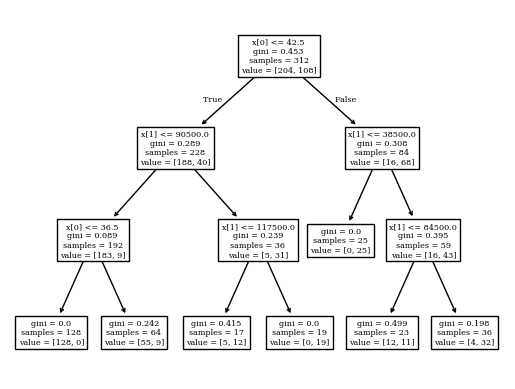

In [33]:
plot_tree(dt_model)
plt.show()

In [34]:
# 성능 평가
accu_dt = accuracy_score(y_pred_dt, y_test)
prec_dt = precision_score(y_pred_dt, y_test)
recall_dt = recall_score(y_pred_dt, y_test)
cm_dt = confusion_matrix(y_pred_dt, y_test)

print("Decision Tree")
print(f"accuracy: {accu_dt:.2f}")
print(f"precision: {prec_dt:.2f}")
print(f"Recall: {recall_dt:.2f}")
print(f"confusion matrix: \n{cm_dt}")

Decision Tree
accuracy: 0.86
precision: 0.75
Recall: 0.84
confusion matrix: 
[[46  7]
 [ 4 21]]


In [35]:
# 3. 랜덤 포레스트
# 파이프라인 생성
pipeline_rfc = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("classifier", RandomForestClassifier(n_estimators=10, random_state=12345)),
    ]
)

pipeline_rfc.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(n_estimators=10, random_state=12345))])

In [36]:
# 교차 검증을 통한 성능 평가
accu_rfc = cross_val_score(pipeline_rfc, X, y, cv=cv, scoring="accuracy")
prec_rfc = cross_val_score(pipeline_rfc, X, y, cv=cv, scoring="precision")
recall_rfc = cross_val_score(pipeline_rfc, X, y, cv=cv, scoring="recall")
f1_rfc = cross_val_score(pipeline_rfc, X, y, cv=cv, scoring="f1")

# 평가 결과 출력
print(f"Cross-Validated Accuracy Scores: {accu_rfc}")
print(f"Mean Accuracy: {accu_rfc.mean():.2f}")

print(f"Cross-Validated Precision Scores: {prec_rfc}")
print(f"Mean Precision: {prec_rfc.mean():.2f}")

print(f"Cross-Validated Recall Scores: {recall_rfc}")
print(f"Mean Recall: {recall_rfc.mean():.2f}")

print(f"Cross-Validated F1 Scores: {f1_rfc}")
print(f"Mean F1 Score: {f1_rfc.mean():.2f}")

Cross-Validated Accuracy Scores: [0.91025641 0.85897436 0.91025641 0.85897436 0.92307692]
Mean Accuracy: 0.89
Cross-Validated Precision Scores: [0.85714286 0.80769231 0.85714286 0.83333333 0.89285714]
Mean Precision: 0.85
Cross-Validated Recall Scores: [0.88888889 0.77777778 0.88888889 0.74074074 0.89285714]
Mean Recall: 0.84
Cross-Validated F1 Scores: [0.87272727 0.79245283 0.87272727 0.78431373 0.89285714]
Mean F1 Score: 0.84


In [37]:
# 4. SVC (Support Vector Classifier)
pipeline_svc = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "classifier",
            SVC(kernel="linear", random_state=12345),
        ),
    ]
)

pipeline_svc.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', SVC(kernel='linear', random_state=12345))])

In [38]:
# 교차 검증을 통한 성능 평가
accu_svc = cross_val_score(pipeline_svc, X, y, cv=cv, scoring="accuracy")
prec_svc = cross_val_score(pipeline_svc, X, y, cv=cv, scoring="precision")
recall_svc = cross_val_score(pipeline_svc, X, y, cv=cv, scoring="recall")
f1_svc = cross_val_score(pipeline_svc, X, y, cv=cv, scoring="f1")

# 평가 결과 출력
print(f"Cross-Validated Accuracy Scores: {accu_svc}")
print(f"Mean Accuracy: {accu_svc.mean():.2f}")

print(f"Cross-Validated Precision Scores: {prec_svc}")
print(f"Mean Precision: {prec_svc.mean():.2f}")

print(f"Cross-Validated Recall Scores: {recall_svc}")
print(f"Mean Recall: {recall_svc.mean():.2f}")

print(f"Cross-Validated F1 Scores: {f1_svc}")
print(f"Mean F1 Score: {f1_svc.mean():.2f}")

Cross-Validated Accuracy Scores: [0.85897436 0.82051282 0.84615385 0.80769231 0.87179487]
Mean Accuracy: 0.84
Cross-Validated Precision Scores: [0.86363636 0.7826087  0.85714286 0.875      0.82142857]
Mean Precision: 0.84
Cross-Validated Recall Scores: [0.7037037  0.66666667 0.66666667 0.51851852 0.82142857]
Mean Recall: 0.68
Cross-Validated F1 Scores: [0.7755102  0.72       0.75       0.65116279 0.82142857]
Mean F1 Score: 0.74


In [39]:
# 모델 성능 비교를 위한 딕셔너리
model_performance = {
    "Logistic Regression": {
        "Accuracy": accu_log.mean(),
        "Precision": prec_log.mean(),
        "Recall": recall_log.mean(),
        "F1 Score": f1_log.mean(),
    },
    "Decision Tree": {
        "Accuracy": accu_dt,
        "Precision": prec_dt,
        "Recall": recall_dt,
        "F1 Score": 2 * (prec_dt * recall_dt) / (prec_dt + recall_dt),
    },
    "Random Forest": {
        "Accuracy": accu_rfc.mean(),
        "Precision": prec_rfc.mean(),
        "Recall": recall_rfc.mean(),
        "F1 Score": f1_rfc.mean(),
    },
    "SVC (Support Vector Classifier)": {
        "Accuracy": accu_svc.mean(),
        "Precision": prec_svc.mean(),
        "Recall": recall_svc.mean(),
        "F1 Score": f1_rfc.mean(),
    },
}

# 성능 출력
for model, metrics in model_performance.items():
    print(f"\n{model}")
    for metric, score in metrics.items():
        print(f"{metric}: {score:.2f}")


Logistic Regression
Accuracy: 0.85
Precision: 0.84
Recall: 0.70
F1 Score: 0.76

Decision Tree
Accuracy: 0.86
Precision: 0.75
Recall: 0.84
F1 Score: 0.79

Random Forest
Accuracy: 0.89
Precision: 0.85
Recall: 0.84
F1 Score: 0.84

SVC (Support Vector Classifier)
Accuracy: 0.84
Precision: 0.84
Recall: 0.68
F1 Score: 0.84


In [40]:
def print_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(
        cm, index=["Not Purchased", "Purchased"], columns=["Not Purchased", "Purchased"]
    )
    print(f"\nConfusion Matrix for {model_name}")
    print(cm_df)


# 혼동 행렬 출력
y_pred_log = pipeline_log.predict(X_test)
print_confusion_matrix(y_test, y_pred_log, "Logistic Regression")

y_pred_dt = dt_model.predict(X_test)
print_confusion_matrix(y_test, y_pred_dt, "Decision Tree")

y_pred_rfc = pipeline_rfc.predict(X_test)
print_confusion_matrix(y_test, y_pred_rfc, "Random Forest")

y_pred_svc = pipeline_svc.predict(X_test)
print_confusion_matrix(y_test, y_pred_svc, "SVC")


Confusion Matrix for Logistic Regression
               Not Purchased  Purchased
Not Purchased             48          2
Purchased                 10         18

Confusion Matrix for Decision Tree
               Not Purchased  Purchased
Not Purchased             46          4
Purchased                  7         21

Confusion Matrix for Random Forest
               Not Purchased  Purchased
Not Purchased             45          5
Purchased                  4         24

Confusion Matrix for SVC
               Not Purchased  Purchased
Not Purchased             48          2
Purchased                 10         18


<Figure size 1200x800 with 0 Axes>

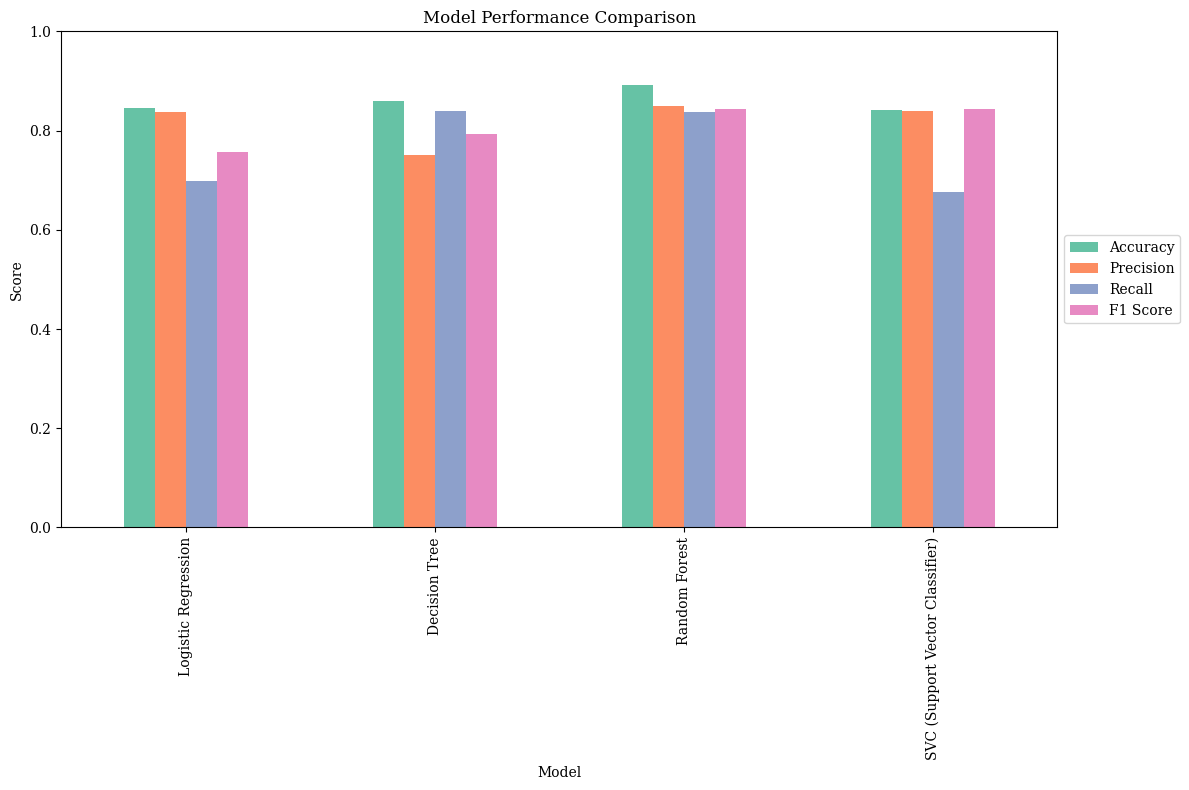

In [41]:
# 성능 지표 시각화
metrics_df = pd.DataFrame(model_performance).T
colors = sns.color_palette("Set2")

plt.figure(figsize=(12, 8))
metrics_df.plot(kind="bar", figsize=(12, 8), color=colors)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

[0.44683721 0.55316279]


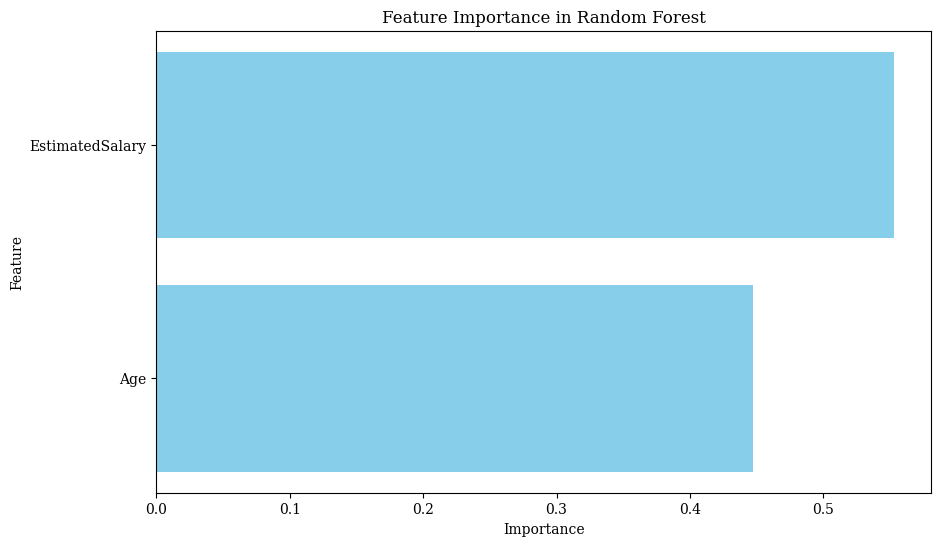

In [42]:
features = X.columns

# 랜덤 포레스트 피처 중요도
feature_importances_rfc = pipeline_rfc.named_steps["classifier"].feature_importances_

print(feature_importances_rfc)

# 피처 중요도 시각화 - 랜덤 포레스트
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances_rfc, color="skyblue")
plt.title("Feature Importance in Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

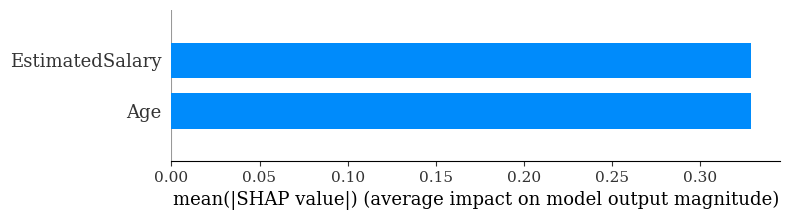

In [43]:
# 모델 훈련이 완료된 후 동일한 데이터로 SHAP 값 계산
rf_model = pipeline_rfc.named_steps["classifier"]  # 파이프라인에서 모델 추출

# SHAP explainer와 SHAP 값 계산
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)  # 여기서 X_test 사용

# Feature importance plot
shap.summary_plot(shap_values[1], X_train, plot_type="bar", feature_names=X.columns)

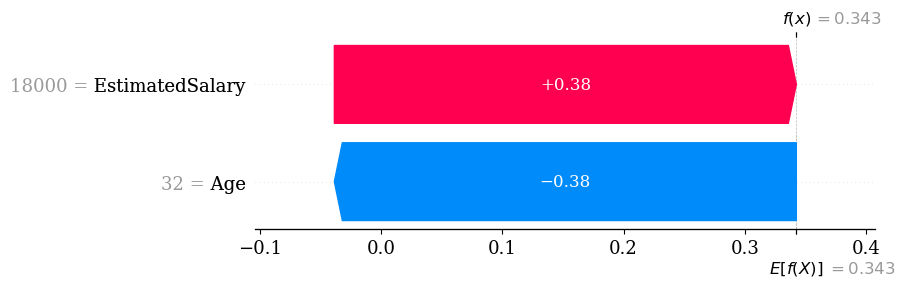

In [44]:
instance_index = 1

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[1][instance_index],
        base_values=explainer.expected_value[1],
        data=X_test.iloc[instance_index],
        feature_names=X_test.columns,
    )
)

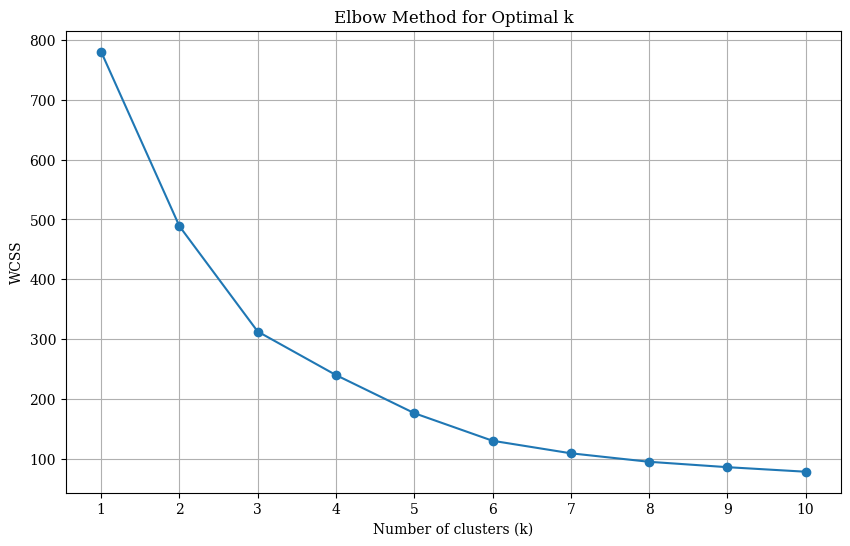

In [45]:
# 데이터 준비
X = data[["EstimatedSalary", "Age"]]

# 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 엘보우 방법 (Elbow Method)
wcss = []
for k in range(1, 11):  # 클러스터 수를 1부터 10까지 테스트
    kmeans = KMeans(
        n_clusters=k, init="k-means++", max_iter=300, n_init=10, random_state=42
    )
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS")
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

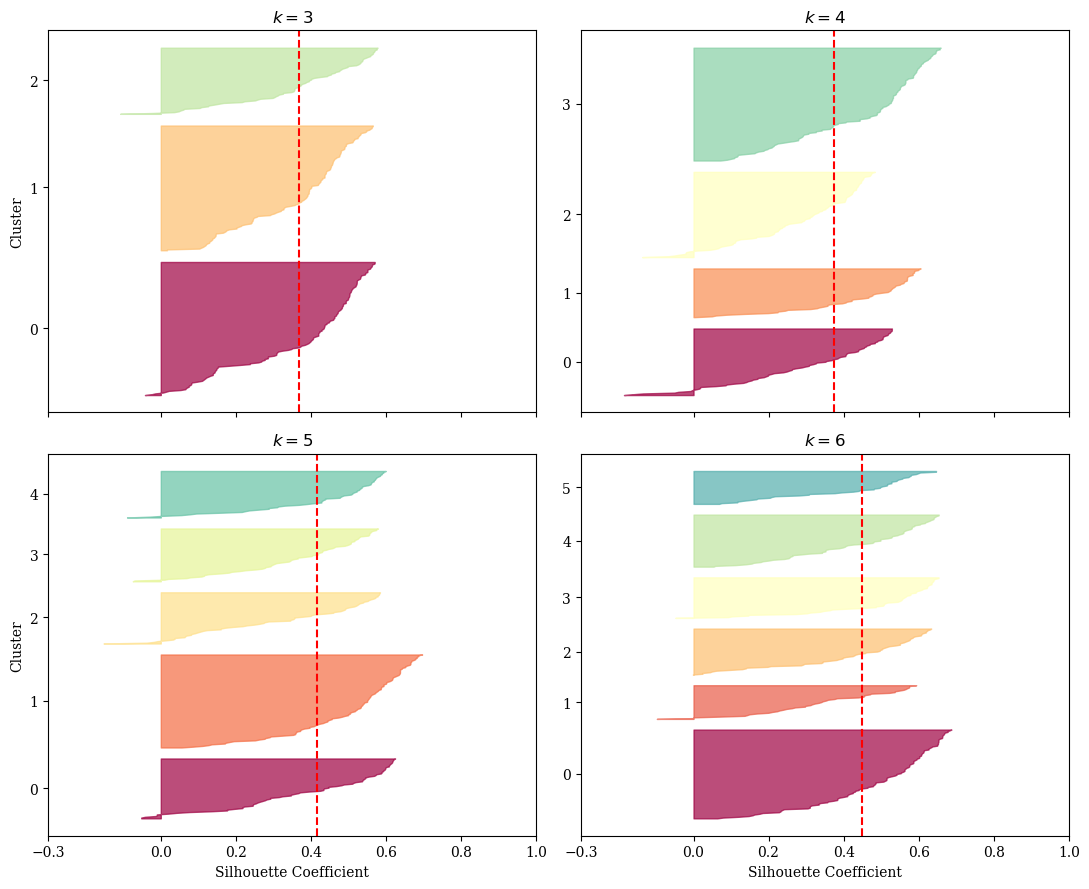

In [46]:
# 클러스터 수 목록
cluster_range = [3, 4, 5, 6]

# KMeans 모델과 실루엣 점수 저장
kmeans_per_k = {}
silhouette_scores = []

for k in cluster_range:
    kmeans = KMeans(
        n_clusters=k, init="k-means++", max_iter=300, n_init=10, random_state=12345
    )
    y_pred = kmeans.fit_predict(X_scaled)
    kmeans_per_k[k] = kmeans
    silhouette_avg = silhouette_score(X_scaled, y_pred)
    silhouette_scores.append(silhouette_avg)

# 실루엣 다이어그램 생성
plt.figure(figsize=(11, 9))

for idx, k in enumerate(cluster_range):
    plt.subplot(2, 2, idx + 1)

    y_pred = kmeans_per_k[k].labels_
    silhouette_coefficients = silhouette_samples(X_scaled, y_pred)

    padding = len(X_scaled) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(
            np.arange(pos, pos + len(coeffs)),
            0,
            coeffs,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    plt.gca().set_xticks([-0.3, 0, 0.2, 0.4, 0.6, 0.8, 1])

    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[idx], color="red", linestyle="--")
    plt.title(f"$k={k}$")

plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_21848\2229986642.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


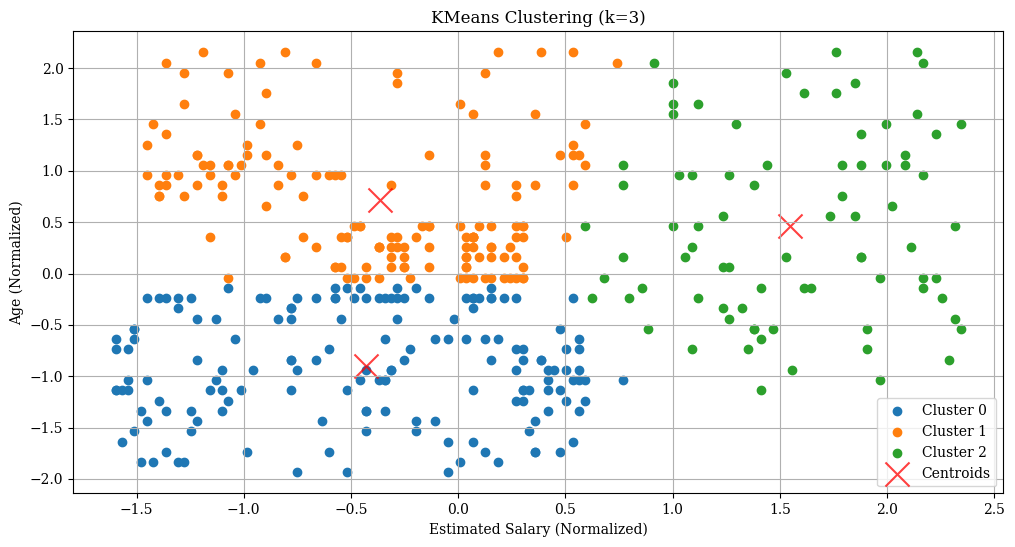

In [47]:
# 클러스터 수와 KMeans 모델 설정
k = 3
kmeans = KMeans(
    n_clusters=k, init="k-means++", max_iter=300, n_init=10, random_state=12345
)
clusters = kmeans.fit_predict(X_scaled)

# 클러스터 중심 (정규화된 스케일)
centers_scaled = kmeans.cluster_centers_

# 클러스터링 결과 시각화 (정규화된 스케일)
plt.figure(figsize=(12, 6))

# 클러스터 시각화
for i in range(k):
    plt.scatter(
        X_scaled[clusters == i, 0],  # EstimatedSalary
        X_scaled[clusters == i, 1],  # Age
        label=f"Cluster {i}",
        cmap="viridis",
        marker="o",
    )

# 각 클러스터의 중심 시각화 (정규화된 스케일)
plt.scatter(
    centers_scaled[:, 0],
    centers_scaled[:, 1],
    c="red",
    s=300,
    alpha=0.75,
    marker="x",
    label="Centroids",
)

# 범례 추가
plt.title(f"KMeans Clustering (k={k})")
plt.xlabel("Estimated Salary (Normalized)")
plt.ylabel("Age (Normalized)")
plt.legend()  # 범례 추가
plt.grid(True)
plt.show()

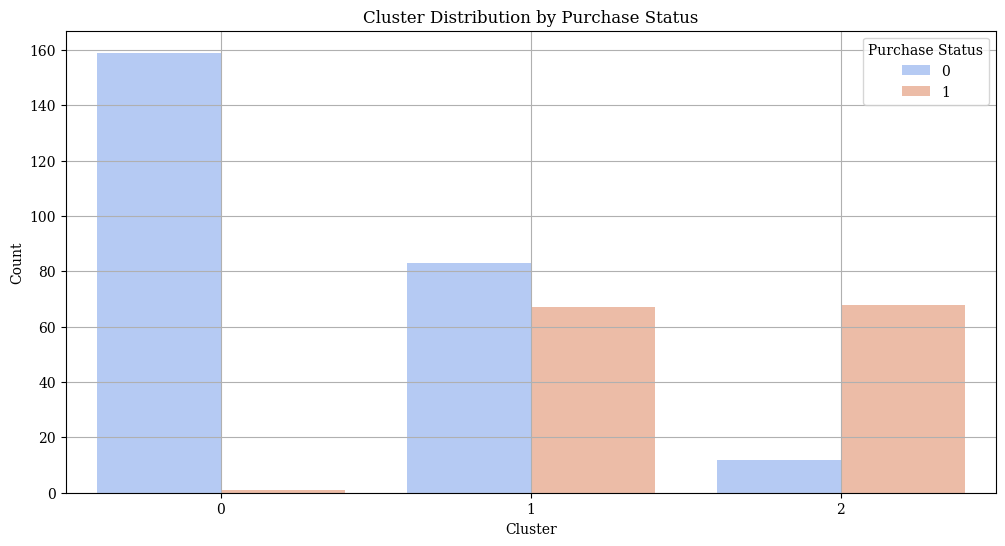

In [48]:
# 데이터에 클러스터 레이블 추가
data["Cluster"] = clusters

# 클러스터와 구매 여부 분포를 보여주는 막대 그래프
plt.figure(figsize=(12, 6))
sns.countplot(x="Cluster", hue="Purchased", data=data, palette="coolwarm")

plt.title("Cluster Distribution by Purchase Status")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="Purchase Status")
plt.grid(True)
plt.show()

In [49]:
# 클러스터별 통계량 계산
cluster_summary = data.groupby("Cluster").agg(
    {
        "EstimatedSalary": ["mean", "median", "std"],
        "Age": ["mean", "median", "std"],
        "Purchased": lambda x: x.value_counts().to_dict(),
    }
)

cluster_summary

EstimatedSalary                                Age                   \
                   mean    median           std       mean median       std   
Cluster                                                                       
0          54943.750000   57500.0  23773.365699  28.337500   28.0  5.218361   
1          57166.666667   59500.0  20173.215236  44.593333   42.0  6.316163   
2         122762.500000  122000.0  17069.659033  42.050000   41.0  8.929967   

              Purchased  
               <lambda>  
Cluster                  
0        {0: 159, 1: 1}  
1        {0: 83, 1: 67}  
2        {1: 68, 0: 12}

In [50]:
# 클러스터별 구매 여부 분석
purchase_distribution = (
    data.groupby(["Cluster", "Purchased"]).size().unstack(fill_value=0)
)

purchase_distribution

Purchased,0,1
Cluster,,
0,159,1
1,83,67
2,12,68


In [51]:
# 표준화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [52]:
# 1. SVR (Support Vector Regression)
svr_model = SVR(kernel="linear")
svr_model.fit(X_train, y_train)
y_pred_svr = svr_model.predict(X_test)

# SVR 평가
mae_svr = mean_absolute_error(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print("\nSVR Evaluation Metrics:")
print(f"MAE: {mae_svr:.2f}")
print(f"MSE: {mse_svr:.2f}")
print(f"RMSE: {rmse_svr:.2f}")
print(f"R^2 Score: {r2_svr:.2f}")


SVR Evaluation Metrics:
MAE: 0.28
MSE: 0.12
RMSE: 0.35
R^2 Score: 0.46


In [53]:
# 2. Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=12345)
dt_regressor.fit(X_train, y_train)
y_pred_dt_reg = dt_regressor.predict(X_test)

# Decision Tree Regressor 평가
mae_dt = mean_absolute_error(y_test, y_pred_dt_reg)
mse_dt = mean_squared_error(y_test, y_pred_dt_reg)
rmse_dt = np.sqrt(mse_dt)
r2_dt = r2_score(y_test, y_pred_dt_reg)

print("\nDecision Tree Regressor Evaluation Metrics:")
print(f"MAE: {mae_dt:.2f}")
print(f"MSE: {mse_dt:.2f}")
print(f"RMSE: {rmse_dt:.2f}")
print(f"R^2 Score: {r2_dt:.2f}")


Decision Tree Regressor Evaluation Metrics:
MAE: 0.16
MSE: 0.16
RMSE: 0.40
R^2 Score: 0.32


In [54]:
# 3. Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=12345)
rf_regressor.fit(X_train, y_train)
y_pred_rf_reg = rf_regressor.predict(X_test)

# Random Forest Regressor 평가
mae_rf = mean_absolute_error(y_test, y_pred_rf_reg)
mse_rf = mean_squared_error(y_test, y_pred_rf_reg)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf_reg)

print("\nRandom Forest Regressor Evaluation Metrics:")
print(f"MAE: {mae_rf:.2f}")
print(f"MSE: {mse_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R^2 Score: {r2_rf:.2f}")


Random Forest Regressor Evaluation Metrics:
MAE: 0.16
MSE: 0.09
RMSE: 0.30
R^2 Score: 0.62


In [55]:
# 4. Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin_reg = lin_reg.predict(X_test)

# Linear Regression 평가
mae_lin = mean_absolute_error(y_test, y_pred_lin_reg)
mse_lin = mean_squared_error(y_test, y_pred_lin_reg)
rmse_lin = np.sqrt(mse_lin)
r2_lin = r2_score(y_test, y_pred_lin_reg)

print("\nLinear Regression Evaluation Metrics:")
print(f"MAE: {mae_lin:.2f}")
print(f"MSE: {mse_lin:.2f}")
print(f"RMSE: {rmse_lin:.2f}")
print(f"R^2 Score: {r2_lin:.2f}")


Linear Regression Evaluation Metrics:
MAE: 0.29
MSE: 0.12
RMSE: 0.35
R^2 Score: 0.47


In [56]:
# 모델 성능 비교를 위한 딕셔너리
model_performance = {
    "SVR (Support Vector Regression)": {
        "MAE": mae_svr,
        "MSE": mse_svr,
        "RMSE": rmse_svr,
        "R^2 Score": r2_svr,
    },
    "Decision Tree Regressor": {
        "MAE": mae_dt,
        "MSE": mse_dt,
        "RMSE": rmse_dt,
        "R^2 Score": r2_dt,
    },
    "Random Forest Regressor": {
        "MAE": mae_rf,
        "MSE": mse_rf,
        "RMSE": rmse_rf,
        "R^2 Score": r2_rf,
    },
    "Linear Regression": {
        "MAE": mae_lin,
        "MSE": mse_lin,
        "RMSE": rmse_lin,
        "R^2 Score": r2_lin,
    },
}

# 성능 출력
for model, metrics in model_performance.items():
    print(f"\n{model}")
    for metric, score in metrics.items():
        print(f"{metric}: {score:.2f}")


SVR (Support Vector Regression)
MAE: 0.28
MSE: 0.12
RMSE: 0.35
R^2 Score: 0.46

Decision Tree Regressor
MAE: 0.16
MSE: 0.16
RMSE: 0.40
R^2 Score: 0.32

Random Forest Regressor
MAE: 0.16
MSE: 0.09
RMSE: 0.30
R^2 Score: 0.62

Linear Regression
MAE: 0.29
MSE: 0.12
RMSE: 0.35
R^2 Score: 0.47


<Figure size 1200x800 with 0 Axes>

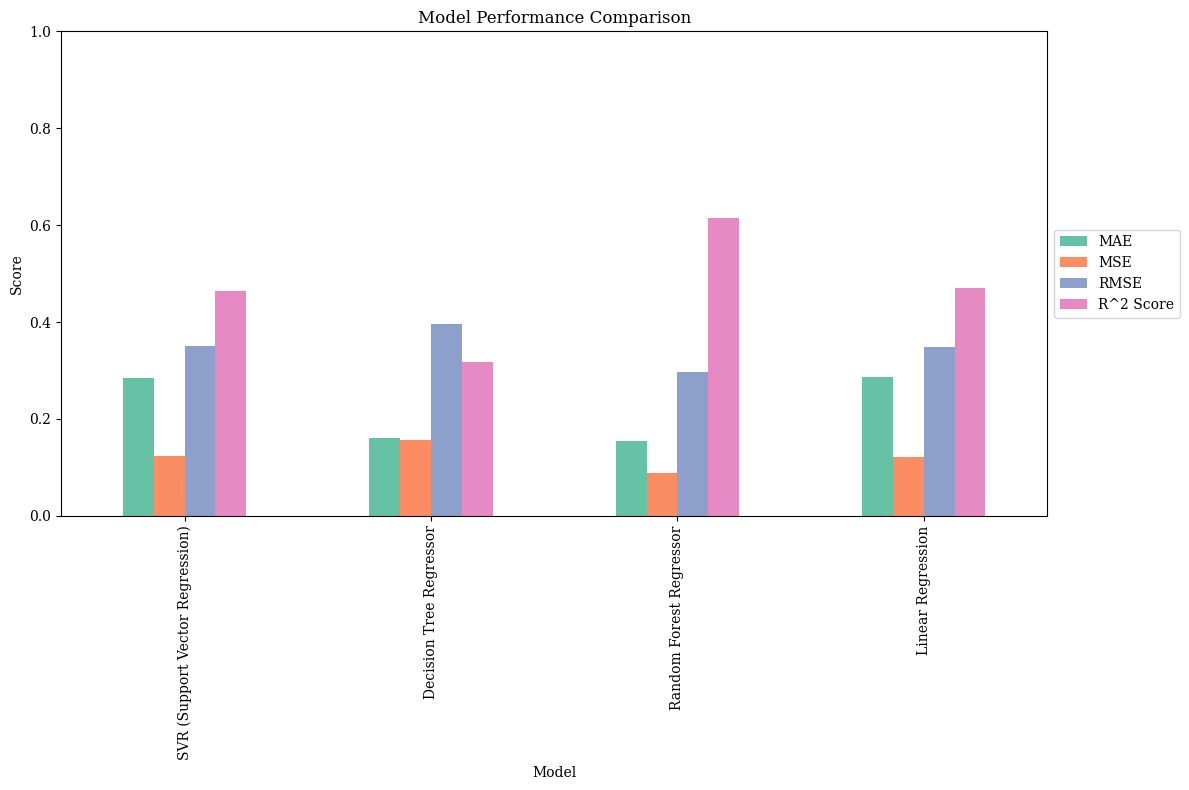

In [57]:
# 성능 지표 시각화
metrics_df = pd.DataFrame(model_performance).T
colors = sns.color_palette("Set2")

plt.figure(figsize=(12, 8))
metrics_df.plot(kind="bar", figsize=(12, 8), color=colors)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()  # 그래프 요소가 잘리는 것을 방지
plt.show()

In [58]:
# 하이퍼파라미터 그리드 설정
param_grid = {
    "n_estimators": [50, 100, 200],  # 트리 개수
    "max_depth": [None, 10, 20, 30],  # 트리의 최대 깊이
    "min_samples_split": [2, 5, 10],  # 내부 노드를 분할하는 데 필요한 최소 샘플 수
    "min_samples_leaf": [1, 2, 4],  # 리프 노드에 필요한 최소 샘플 수
    "bootstrap": [True, False],  # 부트스트랩 샘플링 사용 여부
}

# GridSearchCV 설정
grid_search = GridSearchCV(
    estimator=rf_regressor,
    param_grid=param_grid,
    cv=5,  # 5-겹 교차 검증
    n_jobs=-1,  # 모든 CPU 코어 사용
    verbose=2,  # 진행 상태 출력
    scoring="neg_mean_squared_error",
)  # 성능 평가지표

# GridSearchCV 모델 훈련
grid_search.fit(X_train, y_train)

# 최적 하이퍼파라미터 및 성능 평가
print("Best Parameters:\n", grid_search.best_params_)
print("Best Score (Negative MSE):", grid_search.best_score_)

# 최적 모델을 사용하여 예측
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

# Random Forest Regressor 평가
mae_rf = mean_absolute_error(y_test, y_pred)
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred)

print("\nRandom Forest Regressor Evaluation Metrics:")
print(f"MAE: {mae_rf:.2f}")
print(f"MSE: {mse_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R^2 Score: {r2_rf:.2f}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters:
 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Best Score (Negative MSE): -0.07356888919683181

Random Forest Regressor Evaluation Metrics:
MAE: 0.16
MSE: 0.08
RMSE: 0.28
R^2 Score: 0.66


[0.48027899 0.51972101]


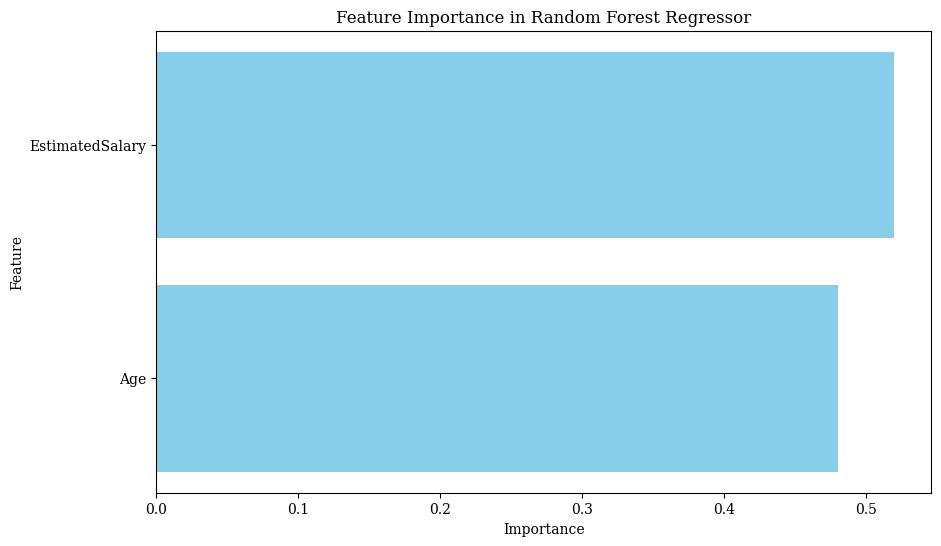

In [59]:
# Random Forest Regressor 피처 중요도
feature_importances_rf_reg = rf_regressor.feature_importances_

print(feature_importances_rf_reg)

# 피처 중요도 시각화 - Random Forest Regressor
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances_rf_reg, color="skyblue")
plt.title("Feature Importance in Random Forest Regressor")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

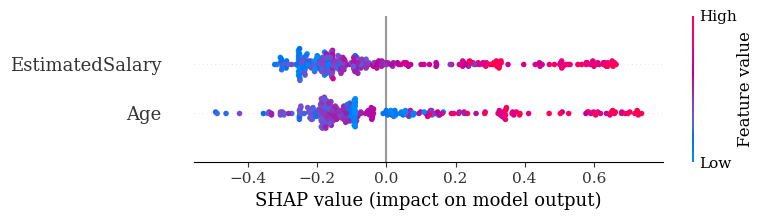

In [60]:
explainer = shap.TreeExplainer(rf_regressor)
shap_train = explainer.shap_values(X_train)
shap_test = explainer.shap_values(X_test)

# Feature importance plot
shap.summary_plot(shap_train, X_train, feature_names=X.columns)

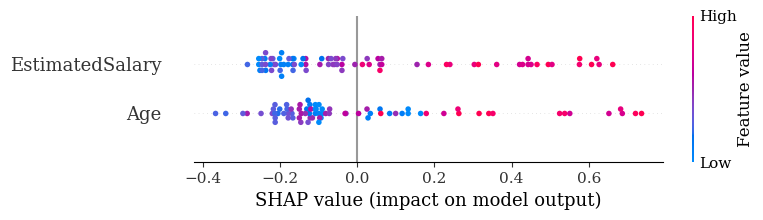

In [61]:
shap.summary_plot(shap_test, X_test, feature_names=X.columns)